# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

###  Импортируем необходимые библиотеки и загружаем датасеты

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats as st
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [4]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Посмотрим 3 датасет

In [5]:
data_0.head(20)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [6]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


### Посмотрим 2 датасет

In [8]:
data_1.head(20)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


### Посмотрим 3 датасет

In [11]:
data_2.head(20)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [12]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Построим графики зависимостей значений в таблице

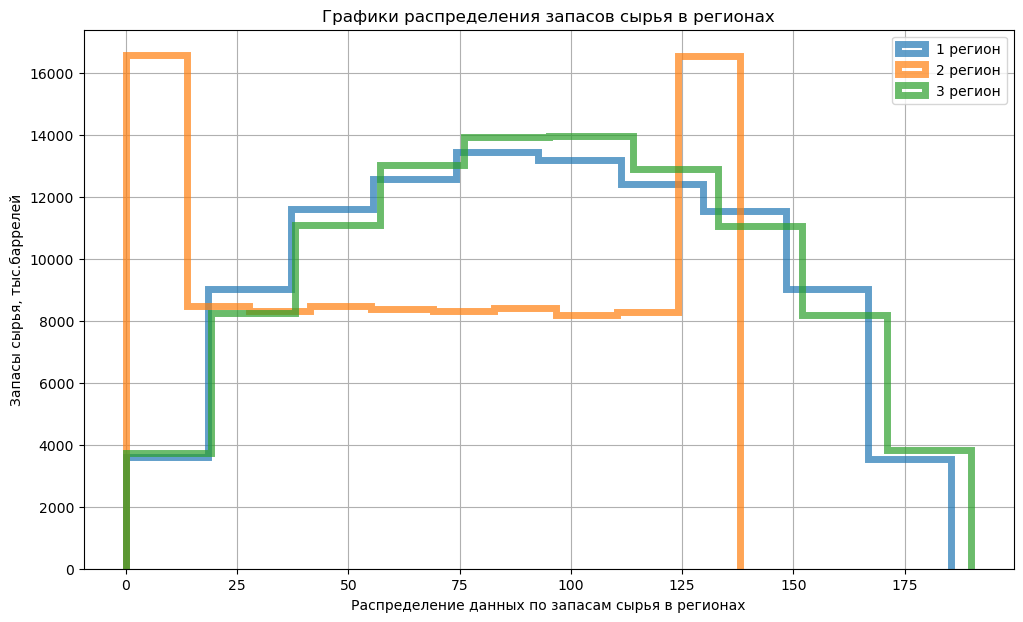

In [14]:
plt.title('Графики распределения запасов сырья в регионах')
ax=data_0['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=5, label='1 регион')
ax1=data_1['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='2 регион', ax=ax)
data_2['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='3 регион', ax=ax1)
plt.xlabel('Распределение данных по запасам сырья в регионах')
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

**Вывод** <br>
Данные успешно загружены и не требуют дополнительной предобработки. На графике отчётливо показана разительно отличающаяся кривая распределения запасов сырья по скважинам 2 региона. Так же заметна довольно высокая корреляция между признаком f2 и целевым признаком product.

## Обучение и проверка модели

### Разделин данные на обучающую и валидационную выборки в соотношении 75:25

In [15]:
data_0_train, data_0_valid = train_test_split(data_0, test_size=0.25, random_state=12345)
data_1_train, data_1_valid = train_test_split(data_1, test_size=0.25, random_state=12345)
data_2_train, data_2_valid = train_test_split(data_2, test_size=0.25, random_state=12345)

In [16]:
features_train_0 = data_0.drop(['product', 'id'], axis=1)
target_train_0 = data_0['product']

features_valid_0 = data_0.drop(['product', 'id'], axis=1)
target_valid_0 = data_0['product']

In [17]:
features_train_1 = data_1.drop(['product', 'id'], axis=1)
target_train_1 = data_1['product']

features_valid_1 = data_1.drop(['product', 'id'], axis=1)
target_valid_1 = data_1['product']

In [18]:
features_train_2 = data_2.drop(['product', 'id'], axis=1)
target_train_2 = data_2['product']

features_valid_2 = data_2.drop(['product', 'id'], axis=1)
target_valid_2 = data_2['product']

### Обучим модель и сделаем предсказания на валидационной выборке

In [19]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
prediction_0 = model_0.predict(features_valid_0)

In [20]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
prediction_1 = model_1.predict(features_valid_1)

In [21]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
prediction_2 = model_2.predict(features_valid_2)

### Найдём средний запас предсказанного сырья и RMSE модели

In [22]:
comparison_tabl = pd.DataFrame(index=['Cредний запас предсказанного сырья','RMSE'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = prediction_0.mean(), mean_squared_error(target_valid_0, prediction_0)**0.5
comparison_tabl['2 регион'] = prediction_1.mean(), mean_squared_error(target_valid_1, prediction_1)**0.5
comparison_tabl['3 регион'] = prediction_2.mean(), mean_squared_error(target_valid_2, prediction_2)**0.5
comparison_tabl

,1 регион,2 регион,3 регион
Cредний запас предсказанного сырья,92.500000,68.825000,95.000000
RMSE,37.691845,0.890376,40.055202


**Вывод** <br>
Модели обучены и проверены на качество предсказания метрикой RMSE. Исходя из полученных данный в нашей сводной таблицы, можно заметить, что величина RMSE во втором регионе сильно отличается от двух других, это связано с тем, что модель обучилась на практически равных по величине данных, и величина ошибки этой модели не может сильно варьирываться.

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраним в отдельных переменных

При разведке региона исследуюем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.
рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью

In [23]:
# Количество скважин
COUNT_OF_WELLS = 200

# Бюджет
BUDGET = 10_000_000_000

# Цена одной скважины
PRICE_ONE_WELL = BUDGET / COUNT_OF_WELLS
#50000000

# Доход с одной единицы продукта
PRICE_ONE_THOUSAND_BARRELS = 450_000

In [24]:
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

print('Cредний запас сырья в 1 регионе: %.2f млн.баррелей'%product_mean_0)
print('Cредний запас сырья в 2 регионе: %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 3 регионе: %.2f млн.баррелей'%product_mean_2)

Cредний запас сырья в 1 регионе: 92.50 млн.баррелей
Cредний запас сырья в 2 регионе: 68.83 млн.баррелей
Cредний запас сырья в 3 регионе: 95.00 млн.баррелей


### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [25]:
v_prod = PRICE_ONE_WELL / PRICE_ONE_THOUSAND_BARRELS
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


**Вывод** <br>
Исходя из полученных данных видно, что среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, поэтому требуется выбрать скважины с максимальными запасами.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Напишем функцию 

In [26]:
def profit(prediction, target):
    probs_sorted = pd.Series(prediction, index=target.index).sort_values(ascending=False)
    max_pred = probs_sorted[:200].sum()
    profit_pred=(max_pred * PRICE_ONE_THOUSAND_BARRELS) - BUDGET
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%max_pred)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000000))

### Прибыль для первого региона

In [27]:
profit(prediction_0, target_valid_0)

Суммарный запас сырья в 200 лучших скважинах составит: 32655.65 тыс.баррелей
Прибыль для полученного объёма сырья составит 4695.04 млн.рублей


### Прибыль для второго региона

In [28]:
profit(prediction_1, target_valid_1)

Суммарный запас сырья в 200 лучших скважинах составит: 27832.02 тыс.баррелей
Прибыль для полученного объёма сырья составит 2524.41 млн.рублей


### Прибыль для третьего региона

In [29]:
profit(prediction_2, target_valid_2)

Суммарный запас сырья в 200 лучших скважинах составит: 31325.41 тыс.баррелей
Прибыль для полученного объёма сырья составит 4096.43 млн.рублей


**Вывод** <br>
Отлично, все три региона потенциально прибыльные. Осталось выяснить, какой регион наиболее выгодный с точки зрения окупаемости вложений и рисков убытка.

## Посчитаем риски и прибыль для каждого региона

In [30]:
def profit_1(prediction, target, count):
    probs_sorted = pd.Series(prediction).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * PRICE_ONE_THOUSAND_BARRELS
    return revenue - BUDGET

In [31]:
def bootstap(target, prediction):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(prediction, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_1(probs_subsample, target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))

In [32]:
bootstap(target_valid_0, prediction_0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 430.84 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -62739.43 млн.руб до: 984446.33 млн.руб
95%-ый доверительный интервал: от 413922.32 млн.руб до 447750.97 млн.руб
Процент вероятности убытка в данном регионе составит 5.2%


In [33]:
bootstap(target_valid_1, prediction_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 462.96 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 55988.53 млн.руб до: 845839.33 млн.руб
95%-ый доверительный интервал: от 450552.47 млн.руб до 475369.36 млн.руб
Процент вероятности убытка в данном регионе составит 1.3%


In [34]:
bootstap(target_valid_2, prediction_2)

  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 380.69 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -169381.45 млн.руб до: 900769.34 млн.руб
95%-ый доверительный интервал: от 363311.24 млн.руб до 398073.86 млн.руб
Процент вероятности убытка в данном регионе составит 8.9%


**Вывод** <br>
Как мы видим, самым прибыльным оказался 2 регион. Средняя прибыль в этом регионе составит 462.96 млн.рублей, при этом процент вероятности убытка в данном регионе всего 1.3%. Два других региона не подходят из-за слишком высокой вероятности убытка. Таким образом не смотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин во втором регионе прогнозируется выше других.

## Вывод

**В ходе исследования было сделано:** <br>

1. Загрузили данные, посмотрели общую информацию о датасетах
2. Построили график распределения запасов сырья
3. Разделили данные на выборки
4. Обчили модели и сделали предсказания
5. Напечатали на экране средний запас предсказанного сырья и RMSE модели
6. Сохранили все ключевые для расчёта значения
7. Рассчитали достаточный объём сырья для безубыточной разработки новой скважины
8. Посчитали прибыль от 200 лучших скважин в каждом регионе
9. Посчитали риски и прибыль для каждого региона
10. Использовали технологию bootstrap


**Общий вывод** <br>
Средний запас ресурсов по регионам недостаточен даже для окупаемости вложений на разработку <br>
Лучшим регионом является второй, так как не смотря на сравнительно меньшие предсказания запасов сырья в 27.75 млн.баррелей, 200 лучших скважин в этом регионе дают вероятность возникновения убытка всего 1.3% и прибыль 462.96 млн.рублей.